### Barcode Demultiplexer Simulator 

- Simulate Demultiplexing using local and semi-global alignment

In [76]:
import sys
sys.path.append("/home/emre/github_repo/MinION")
from minION import analyser
from minION import consensus
from minION import demultiplexer
import importlib
from minION.util import IO_processor
from minION.util.globals import BARCODES, MEDAKA_MODELS, DEFAULT_TARGETS
importlib.reload(IO_processor)
importlib.reload(analyser)
importlib.reload(consensus)
importlib.reload(demultiplexer)
from pathlib import Path
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import random

In [77]:
# Plotly version
def barcode_score(summary):
    fig = px.histogram(summary, x="barcode_score", nbins=100, 
                       title="Barcode Score Distribution", labels={'barcode_score': 'Barcode Score', 'count': 'Frequency'})
    fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
    fig.update_layout(width=600, height=400)
    return fig

def barcode_barplot(summary, barcode_id="barcode_arrangement", ylim=None):
    barcodes = summary[barcode_id].value_counts().reset_index()
    fig = px.bar(barcodes, x=barcode_id, y="count", 
                 title="Barcode Frequency", labels={'index': 'Barcode ID', barcode_id: 'Frequency'})
    fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
    fig.update_layout(width=600, height=400)

    if ylim:
        fig.update_layout(yaxis=dict(range=[0, ylim]))

    return fig

def barcode_arrangement(summary, plot=True):
    barcode_arrangements = summary["barcode_arrangement"].value_counts().reset_index()

    if plot:
        fig = px.bar(barcode_arrangements, x='barcode_score', y='barcode_arrangement', 
                     title="Barcode Frequency", labels={'index': 'Barcode ID', 'barcode_arrangement': 'Frequency'})
        fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
        fig.update_layout(width=600, height=400)
        return fig
    else:
        return barcode_arrangements

In [78]:

def check_gc_content(sequence, desired_gc_fraction, tolerance=0.05):
    """
    Check if the GC content of the sequence is within the desired range.
    """
    gc_count = sum(1 for nucleotide in sequence if nucleotide in ['G', 'C'])
    gc_fraction = gc_count / len(sequence)
    return abs(gc_fraction - desired_gc_fraction) <= tolerance

def generate_gc_content_sequence(length, desired_gc_fraction):
    """
    Iteratively generate a random DNA sequence until it has the desired GC content.
    """
    while True:
        sequence = ''.join(random.choice('ATCG') for _ in range(length))
        if check_gc_content(sequence, desired_gc_fraction):
            return sequence


def introduce_mutations(sequence, mutation_rate):
    """
    Introduce mutations in a sequence with the specified mutation rate.
    The mutations include substitution, insertion, and deletion.
    """
    mutated_sequence = ''
    nucleotides = ['A', 'C', 'G', 'T']
    
    weights = {'substitution': 0.2, 'insertion': 0.4, 'deletion': 0.4}

    i = 0
    while i < len(sequence):
        if random.random() < mutation_rate:
            mutation_type = random.choices(['substitution', 'insertion', 'deletion'], weights=[weights['substitution'], weights['insertion'], weights['deletion']])[0]
            if mutation_type == 'substitution':
                mutated_sequence += random.choice([n for n in nucleotides if n != sequence[i]])
                i += 1
            elif mutation_type == 'insertion':
                mutated_sequence += random.choice(nucleotides)
            else:  # deletion
                i += 1
                continue
        else:
            mutated_sequence += sequence[i]
            i += 1
    return mutated_sequence

### Generate the synthetic sequences

- GC content of 60 %


In [132]:

def write_to_fastq(filename, barcodes, sequence_length, barcode_position_start, barcode_position_end, mutation_rate, num_sequences, num_noise):
    """
    Write mutated sequences for each barcode into a FASTQ file using a fixed surrounding sequence.
    """
    with open(filename, 'wt') as fastq_file:
        for i in range(num_sequences):
            # Generate one surrounding sequence for the set of barcodes
            surrounding_sequence = generate_gc_content_sequence(sequence_length, 0.6)

            for barcode_name, barcode_sequence in barcodes.items():
                # Introduce mutations in the barcode sequence
                mutated_barcode_sequence = introduce_mutations(barcode_sequence, mutation_rate)

                # Insert the mutated barcode sequence in the surrounding sequence
                mutated_sequence = surrounding_sequence[:barcode_position_start] + mutated_barcode_sequence + surrounding_sequence[barcode_position_end:]
                
                # Assign quality scores
                quality_scores = "I" * len(mutated_sequence)
                
                # Write to FASTQ file
                fastq_file.write(f"@seq_{i + 1}_{barcode_name}\n")
                fastq_file.write(f"{mutated_sequence}\n")
                fastq_file.write("+\n")
                fastq_file.write(f"{quality_scores}\n")


        for i in range(num_noise):
        # Generate random noise sequence
            noise_sequence = generate_gc_content_sequence(sequence_length, 0.6)
            
            # Assign quality scores
            quality_scores = "I" * sequence_length
            
            # Write to FASTQ file
            fastq_file.write(f"@noise_{i + 1}\n")
            fastq_file.write(f"{noise_sequence}\n")
            fastq_file.write("+\n")
            fastq_file.write(f"{quality_scores}\n")



            
# Define the barcodes and other parameters
barcodes = {
    "RB01": "AAGAAAGTTGTCGGTGTCTTTGTG", 
    "RB02": "TCGATTCCGTTTGTAGTCGTCTGT", 
    "RB03": "GAGTCTTGTGTCCCAGTTACCAGG",
    "RB04": "TTCGGATTCTATCGTGTTTCCCTA",
    "RB05": "CTTGTCCAGGGTTTGTGTAACCTT",
    "RB06": "TTCTCGCAAAGGCAGAAAGTAGTC",
    "RB07": "GTGTTACCGTGGGAATGAATCCTT",
    "RB08": "TTCAGGGAACAAACCAAGTTACGT"
}


sequence_length = 150
barcode_position_start = 70
barcode_position_end = 94
mutation_rate = 0.3 # 10% mutation rate
num_sequences = 10000
num_noise = 0

# Write sequences to a FASTQ file
write_to_fastq("data/mutated_sequences_03.fastq", barcodes, sequence_length, barcode_position_start, barcode_position_end, mutation_rate, num_sequences, num_noise)


In [95]:
file_names = ["00_0", "00_1", "00_2", "01_0", "01_1", "01_2", "02_0", "02_1", "02_2"]

for file in file_names:
    demultiplexer.run_demultiplexer_single(Path("data") / file, BARCODES, 50, 50, basecall_folder = Path("data") / file)

Data_Path: /home/emre/github_repo/MinION/minION/barcoding
Barcode_rbc: FBC-sim
RBC Prompt: guppy_barcoder --input_path data/00_0 --save_path data/00_0/demultiplex_50 --data_path /home/emre/github_repo/MinION/minION/barcoding --barcode_kits FBC-sim --min_score_barcode_front 50
ONT Guppy barcoding software version 6.5.7+ca6d6af
input path:         data/00_0
save path:          data/00_0/demultiplex_50
min. score front:   50
min. score rear:    50

Found 1 input files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 7705 ms.
Data_Path: /home/emre/github_repo/MinION/minION/barcoding
Barcode_rbc: FBC-sim
RBC Prompt: guppy_barcoder --input_path data/00_1 --save_path data/00_1/demultiplex_50 --data_path /home/emre/github_repo/MinION/minION/barcoding --barcode_kits FBC-sim --min_score_barcode_front 50
ONT Guppy barcoding software version 6.5.7+ca6d6af
input path:         data

In [133]:
demultiplexer.run_demultiplexer_single(Path("data") / "03_0", BARCODES, 50, 50, basecall_folder = Path("data") / "03_0")

Data_Path: /home/emre/github_repo/MinION/minION/barcoding
Barcode_rbc: FBC-sim
RBC Prompt: guppy_barcoder --input_path data/03_0 --save_path data/03_0/demultiplex_50 --data_path /home/emre/github_repo/MinION/minION/barcoding --barcode_kits FBC-sim --min_score_barcode_front 50
ONT Guppy barcoding software version 6.5.7+ca6d6af
input path:         data/03_0
save path:          data/03_0/demultiplex_50
min. score front:   50
min. score rear:    50

Found 1 input files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 7536 ms.


True

In [134]:
summary_01 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/01_0/demultiplex_50"))
summary_02 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/02_0/demultiplex_50"))
summary_03 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/03_0/demultiplex_50"))

In [135]:
summary.head(20)

,read_id,barcode_arrangement,barcode_full_arrangement,barcode_kit,barcode_variant,barcode_score,barcode_front_id,barcode_front_score,barcode_front_refseq,barcode_front_foundseq,barcode_front_foundseq_length,barcode_front_begin_index,barcode_rear_id,barcode_rear_score,barcode_rear_refseq,barcode_rear_foundseq,barcode_rear_foundseq_length,barcode_rear_end_index
0,seq_1_RB01,unclassified,RB01,Well,NaN,62.0833,RB01_FWD,38.8333,CACAAAGACACCGACAACTTTCTT,CAGCGAAGAAATTGTCTT,18,65,RB01_REV,62.0833,AAGAAAGTTGTCGGTGTCTTTGTG,AAGAAATTGTCTTGTATTTGTG,22,56
1,seq_1_RB02,unclassified,RB02,Well,NaN,75.0000,RB02_FWD,37.6667,ACAGACGACTACAAACGGAATCGA,GAGTACAATAGGATCA,16,29,RB02_REV,75.0000,TCGATTCCGTTTGTAGTCGTCTGT,TCGATTCCGTTTTGTAGTGTTG,22,55
2,seq_1_RB03,unclassified,RB03,Well,NaN,67.9167,RB03_FWD,22.9167,CCTGGTAACTGGGACACAAGACTC,CTGTTGGGAGTACAATAGGATC,22,22,RB03_REV,67.9167,GAGTCTTGTGTCCCAGTTACCAGG,GAGTTTTGATGTCCAGTTACAGG,23,55
3,seq_1_RB04,RB04,RB04,Well,NaN,87.5000,RB04_FWD,87.5000,TTCGGATTCTATCGTGTTTCCCTA,TTCGGATTCATCGTGTTTCCTA,22,70,RB04_REV,31.3333,TAGGGAAACACGATAGAATCCGAA,TCAGGGACAACCGTCGGACGA,21,85
4,seq_1_RB05,RB05,RB05,Well,NaN,79.9167,RB05_FWD,79.9167,CTTGTCCAGGGTTTGTGTAACCTT,CATTCTCCAGGGTTTGTGTAACCTT,25,70,RB05_REV,24.2500,AAGGTTACACAAACCCTGGACAAG,AGGGACAACCGTCGGACGAG,20,87
5,seq_1_RB06,RB06,RB06,Well,NaN,74.2500,RB06_FWD,74.2500,TTCTCGCAAAGGCAGAAAGTAGTC,TTCTCGCAAATGCAGAAAGTGC,22,70,RB06_REV,10.5833,GACTACTTTCTGCCTTTGCGAGAA,GAGCCAGCGTTCTCGCAAATGCAGAA,26,61
6,seq_1_RB07,RB07,RB07,Well,NaN,80.5000,RB07_FWD,80.5000,GTGTTACCGTGGGAATGAATCCTT,GTTTACCGTGGGGAATGATCCTT,23,70,RB07_REV,11.8333,AAGGATTCATTCCCACGGTAACAC,AATGATCCTTGACCTCAGTTACGC,24,42
7,seq_1_RB08,RB08,RB08,Well,NaN,72.5000,RB08_FWD,72.5000,TTCAGGGAACAAACCAAGTTACGT,TCAGGGACAAACCAATTAGCGT,22,70,RB08_REV,26.6667,ACGTAACTTGGTTTGTTCCCTGAA,ATGTCTGGGTGTCCCACA,18,20
8,seq_2_RB01,RB01,RB01,Well,NaN,73.5000,RB01_FWD,25.8333,CACAAAGACACCGACAACTTTCTT,CACGGAAGCCCGTCGTGTTCTT,22,18,RB01_REV,73.5000,AAGAAAGTTGTCGGTGTCTTTGTG,AAGAACAGTTGCGGTGTCTTGCTG,24,53
9,seq_2_RB02,RB02,RB02,Well,NaN,69.1667,RB02_FWD,42.4167,ACAGACGACTACAAACGGAATCGA,ACAGTCGCATACAAGCACGGAAG,23,3,RB02_REV,69.1667,TCGATTCCGTTTGTAGTCGTCTGT,TGATCCGTCTGTAGTCGTCTG,21,57


Text(0, 0.5, 'Frequency')

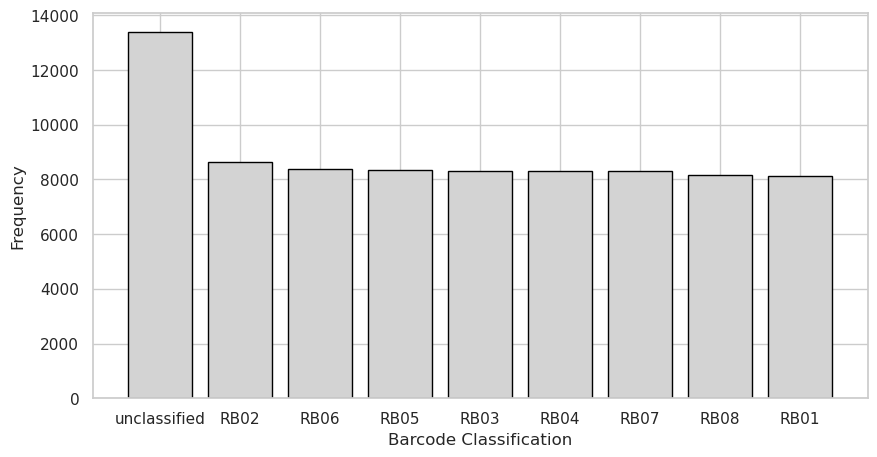

In [117]:
summary["barcode_arrangement"].value_counts().reset_index()

# SNS
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(summary["barcode_arrangement"].value_counts().index, summary["barcode_arrangement"].value_counts().values, color="lightgrey", edgecolor="black")
#plt.title("Barcode Arrangement - Guppy (Semi-Global)")
plt.xlabel("Barcode Classification")
plt.ylabel("Frequency")



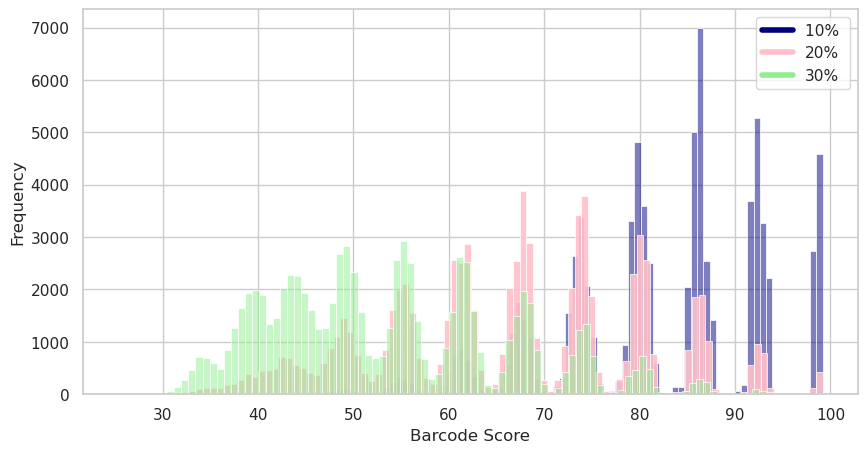

In [138]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary_01, x="barcode_score", bins=100, kde=False, ax=ax, color="navy", alpha=0.5)
sns.histplot(data=summary_02, x="barcode_score", bins=100, kde=False, ax=ax, color="pink", alpha=0.9)
sns.histplot(data=summary_03, x="barcode_score", bins=100, kde=False, ax=ax, color="lightgreen", alpha=0.5)

# Add custom legend with the correct colors
custom_lines = [plt.Line2D([0], [0], color="navy", lw=4),
                plt.Line2D([0], [0], color="pink", lw=4),
                plt.Line2D([0], [0], color="lightgreen", lw=4)]

ax.legend(custom_lines, ['10% ', '20%', "30%"])
# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
#ax.set_title("Barcode Score Distribution")

# Add a red vertical line
#ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
plt.savefig("barcode_score_distribution_guppy.png", dpi=300)
plt.show()

In [139]:
summary["barcode_score"].describe()

count    80000.000000
mean        66.267682
std         13.619840
min         27.000000
25%         55.833300
50%         67.250000
75%         75.000000
max         99.166700
Name: barcode_score, dtype: float64

In [140]:
summary["barcode_arrangement"].value_counts().reset_index()

,barcode_arrangement,count
0,unclassified,13409
1,RB02,8656
2,RB06,8374
3,RB05,8338
4,RB03,8328
5,RB04,8300
6,RB07,8293
7,RB08,8158
8,RB01,8144


In [141]:
def split_read_id(read_id):
    """
    Split the read ID into the barcode ID and the read ID.
    """
    parts = read_id.split("_")
    barcode_id = parts[-1]
    read_id_prefix = "_".join(parts[:-1])
    return barcode_id


In [142]:
summary["Truth"] = summary["read_id"].apply(split_read_id)

In [146]:
def get_correctly_classified_barcodes(summary_df, barcode_truth_mapping):
    """
    Get correctly classified barcodes from the summary dataframe and compile them into a single DataFrame.

    :param summary_df: Pandas DataFrame containing barcode classification results
    :param barcode_truth_mapping: Dictionary where keys are the expected barcode arrangements
                                  and values are the corresponding truth values.
    :return: DataFrame with an additional column 'Barcode' indicating the barcode name
    """
    frames = []
    for arrangement, truth in barcode_truth_mapping.items():
        temp_df = summary_df[(summary_df["barcode_arrangement"] == arrangement) & (summary_df["Truth"] == truth)].copy()
        temp_df['Barcode'] = truth
        frames.append(temp_df)
    
    return pd.concat(frames)
# Example usage
barcode_truth_mapping = {
    "barcode01": "RB01",
    "barcode02": "RB02",
    "barcode03": "RB03",
    "barcode04": "RB04",
    "barcode05": "RB05",
    "barcode06": "RB06",
    "barcode07": "RB07",
    "barcode08": "RB08"
}


In [147]:
correctly_classified_df = get_correctly_classified_barcodes(summary_01, barcode_truth_mapping)


KeyError: 'Truth'

In [145]:
correctly_classified_df

,read_id,barcode_arrangement,barcode_full_arrangement,barcode_kit,barcode_variant,barcode_score,barcode_front_id,barcode_front_score,barcode_front_refseq,barcode_front_foundseq,barcode_front_foundseq_length,barcode_front_begin_index,barcode_rear_id,barcode_rear_score,barcode_rear_refseq,barcode_rear_foundseq,barcode_rear_foundseq_length,barcode_rear_end_index,Truth,Barcode


In [294]:
# Correctly classified
rb01 = summary[(summary["barcode_arrangement"] == "barcode01") & (summary["Truth"] == "RB01")]
rb02 = summary[(summary["barcode_arrangement"] == "barcode02") & (summary["Truth"] == "RB02")]
rb03 = summary[(summary["barcode_arrangement"] == "barcode03") & (summary["Truth"] == "RB03")]

In [295]:
summary_cpp = analyser.read_summary_file(Path('/home/emre/github_repo/MinION/examples/data/Demultiplex_cpp/50'))

Text(0, 0.5, 'Frequency')

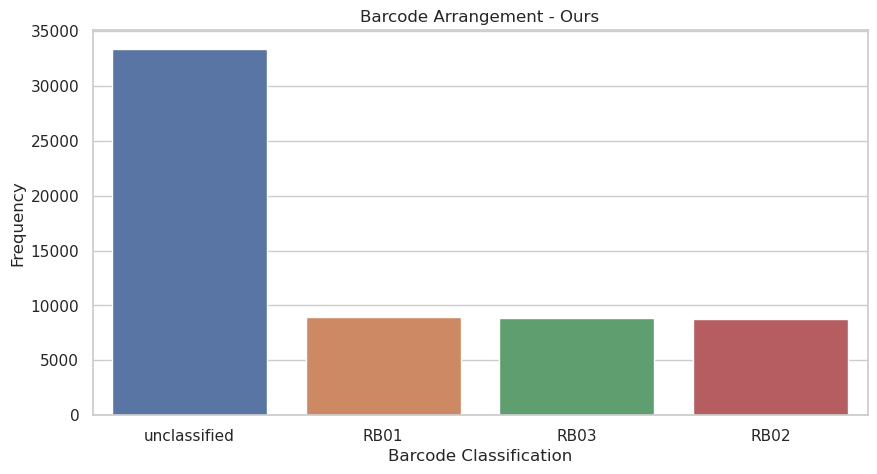

In [296]:
summary_cpp["RBC"].value_counts().reset_index()

# SNS
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.barplot(x="RBC", y="count", data=summary_cpp["RBC"].value_counts().reset_index())
plt.title("Barcode Arrangement - Ours")
plt.xlabel("Barcode Classification")
plt.ylabel("Frequency")


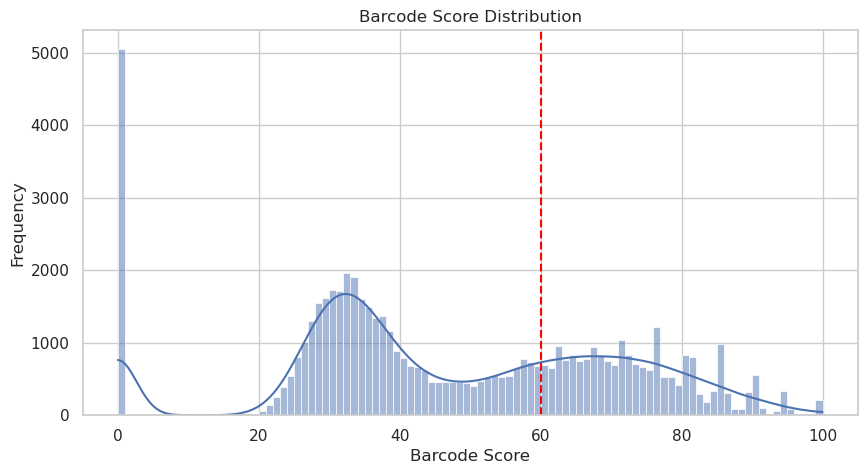

In [297]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary_cpp, x="RBC_Score", bins=100, kde=True, ax=ax)

# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
ax.set_title("Barcode Score Distribution")

# Add a red vertical line
ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
plt.show()

In [298]:
summary_cpp["Truth"] = summary_cpp["ID"].apply(split_read_id)

rb01_cpp = summary_cpp[(summary_cpp["RBC"] == "RB01") & (summary_cpp["Truth"] == "RB01")]
rb02_cpp = summary_cpp[(summary_cpp["RBC"] == "RB02") & (summary_cpp["Truth"] == "RB02")]
rb03_cpp = summary_cpp[(summary_cpp["RBC"] == "RB03") & (summary_cpp["Truth"] == "RB03")]

In [299]:
# Recall
num_seq = 10000
Recall = {"Guppy" : {"RB01" : len(rb01) / num_seq, "RB02" : len(rb02) / num_seq, "RB03" : len(rb03) / num_seq}, "Local" : {"RB01" : len(rb01_cpp) / num_seq, "RB02" : len(rb02_cpp) / num_seq, "RB03" : len(rb03_cpp) / num_seq}}
df_recall = pd.DataFrame.from_dict(Recall)
df_recall["Barcode"] = df_recall.index

In [300]:
df_recall = df_recall.melt(id_vars=["Barcode"], var_name="Alignment", value_name="Recall")

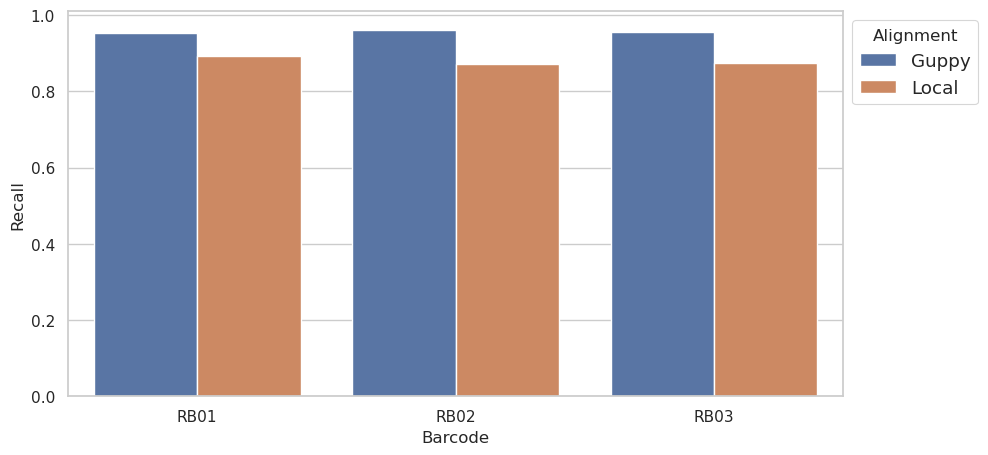

In [301]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.set_theme(style="whitegrid")
sns.barplot(x="Barcode", y="Recall", hue="Alignment", data=df_recall)
sns.set_context("paper", font_scale=1.5)
plt.xlabel("Barcode")
plt.ylabel("Recall")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=1)

In [302]:
# Calculate misclassification rate


In [303]:
classified_guppy = summary["barcode_arrangement"].value_counts().reset_index()

det_rb01 = classified_guppy.loc[classified_guppy["barcode_arrangement"] == "barcode01"]["count"].values[0]
det_rb02 = classified_guppy.loc[classified_guppy["barcode_arrangement"] == "barcode02"]["count"].values[0]
det_rb03 = classified_guppy.loc[classified_guppy["barcode_arrangement"] == "barcode03"]["count"].values[0]


classified_cpp = summary_cpp["RBC"].value_counts().reset_index()

det_rb01_cpp = classified_cpp.loc[classified_cpp["RBC"] == "RB01"]["count"].values[0]
det_rb02_cpp = classified_cpp.loc[classified_cpp["RBC"] == "RB02"]["count"].values[0]
det_rb03_cpp = classified_cpp.loc[classified_cpp["RBC"] == "RB03"]["count"].values[0]

Classification = {"Guppy" : {"RB01" : len(rb01) / det_rb01, "RB02" : len(rb02) / det_rb02, "RB03" : len(rb03) / det_rb03}, "Local" : {"RB01" : len(rb01_cpp) / det_rb01_cpp, "RB02" : len(rb02_cpp) / det_rb02_cpp, "RB03" : len(rb03_cpp) / det_rb03_cpp}}



In [304]:
class_df = pd.DataFrame(Classification)

In [305]:
class_df

,Guppy,Local
RB01,0.966244,0.994538
RB02,0.824745,0.991357
RB03,0.833392,0.989246


In [260]:
det_rb01_cpp

9954